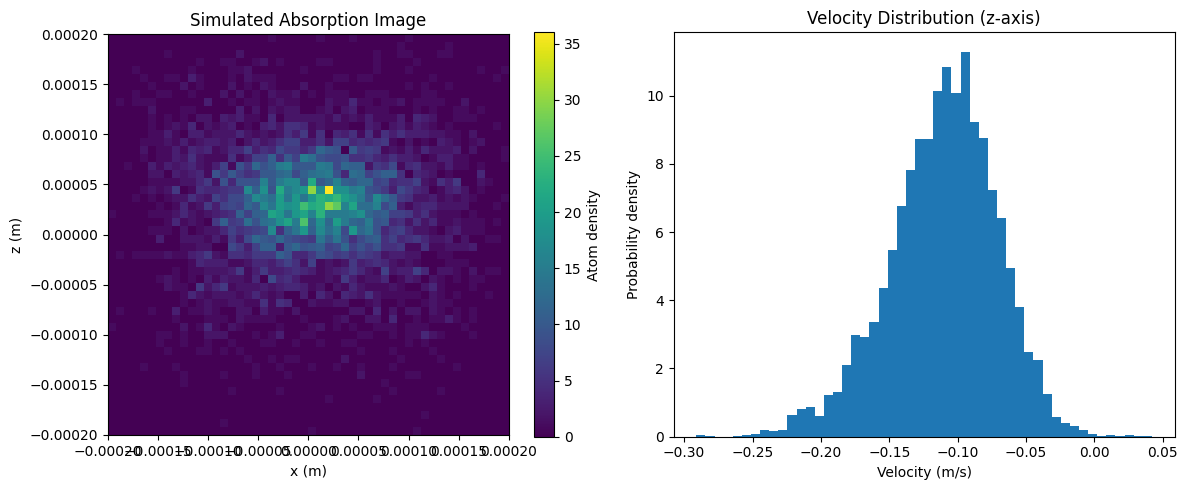

Final temperature: 16.83 µK


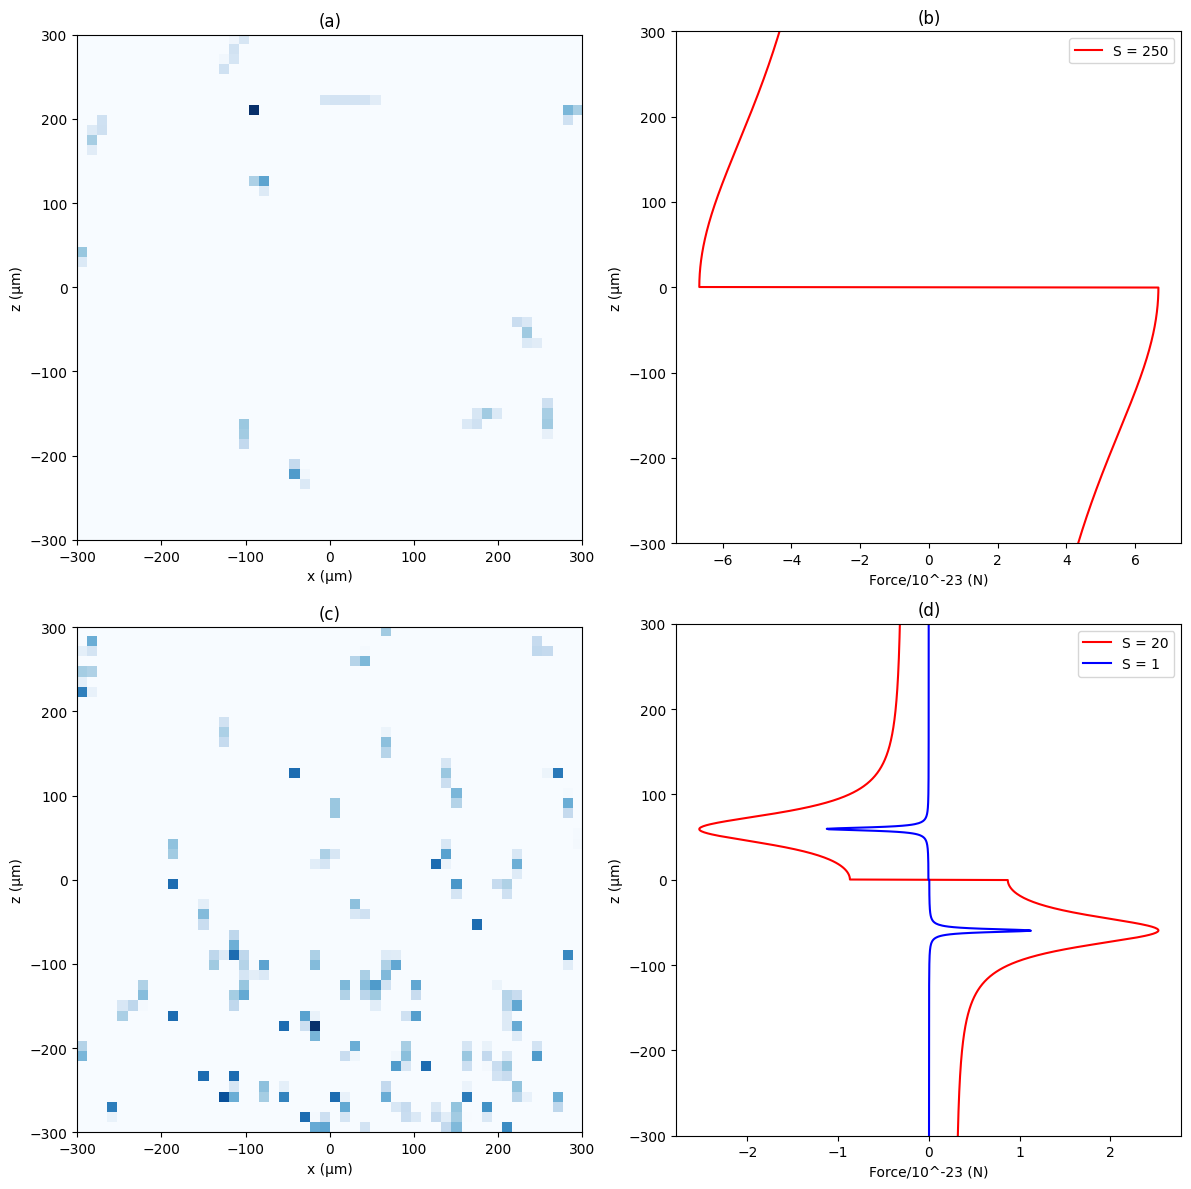

In [1]:
import numpy as np
from scipy.constants import h, hbar, mu_0, c, k, atomic_mass, g
import matplotlib.pyplot as plt

# Constants
M = 88 * atomic_mass  # Mass of 88Sr
lambda_light = 689e-9  # Wavelength of 689 nm light
k_light = 2 * np.pi / lambda_light  # Wavenumber
gamma = 2 * np.pi * 7.5e3  # Natural linewidth
I_sat = 3 * np.pi * h * c * gamma / (2 * lambda_light**3)  # Saturation intensity
g_factor = 1.5  # Lande g-factor for 3P1 state
mu_B = 9.27400968e-24  # Bohr magneton

def initialize_atoms(num_atoms, initial_ellipsoid, initial_temperature):
    """
    Initialize atoms with random positions in an ellipsoid and velocities from a Maxwell-Boltzmann distribution.
    """
    positions = np.random.randn(num_atoms, 3) * initial_ellipsoid
    velocities = np.random.randn(num_atoms, 3) * np.sqrt(k * initial_temperature / M)
    return positions, velocities

def set_simulation_parameters(delta, S, gradient):
    """
    Set simulation parameters.
    """
    return {
        'delta': delta,
        'S': S,
        'gradient': gradient,
        'gamma_prime': gamma * np.sqrt(1 + S)
    }

def calculate_magnetic_field(positions, gradient):
    """
    Calculate the local magnetic field for each atom.
    """
    return gradient * np.column_stack((positions[:, 0], positions[:, 1], -2 * positions[:, 2]))

def calculate_coupling_strength(B_local, k_vectors):
    """
    Calculate the coupling strength for each atom and laser beam.
    """
    B_norm = np.linalg.norm(B_local, axis=1)[:, np.newaxis]
    k_norm = np.linalg.norm(k_vectors, axis=1)
    
    # Compute the dot product for all combinations of B_local and k_vectors
    dot_products = np.dot(B_local, k_vectors.T)
    
    # Compute cos(theta) for all combinations
    cos_theta = dot_products / (B_norm * k_norm)
    
    # Ensure cos_theta is in the valid range [-1, 1] to avoid NaN in arccos
    cos_theta = np.clip(cos_theta, -1, 1)
    
    # Compute theta
    theta = np.arccos(cos_theta)
    
    # Compute W for all combinations
    W = np.column_stack((
        (1 + np.cos(theta))**2 / 4,
        np.sin(theta)**2 / 2,
        (1 - np.cos(theta))**2 / 4
    ))
    
    return W

def calculate_force(positions, velocities, params, k_vectors):
    B_local = calculate_magnetic_field(positions, params['gradient'])
    W = calculate_coupling_strength(B_local, k_vectors)
    delta_omega_z = g_factor * mu_B * np.linalg.norm(B_local, axis=1) / hbar
    
    force = np.zeros_like(positions)
    for i, k in enumerate(k_vectors):
        doppler_shift = np.dot(velocities, k)
        detuning = params['delta'] - doppler_shift[:, np.newaxis] - delta_omega_z[:, np.newaxis] * np.array([-1, 0, 1])
        scattering_rate = 0.5 * gamma * W[:, i, np.newaxis] * params['S'] / (1 + W[:, i, np.newaxis] * params['S'] + 4 * (detuning / params['gamma_prime'])**2)
        force += np.sum(scattering_rate, axis=1)[:, np.newaxis] * hbar * k_light * k

    return force

def calculate_nMOT_distribution(x, z, delta, S, gradient):
    B = gradient * np.sqrt(x**2 + z**2)
    delta_omega_z = g_factor * mu_B * B / hbar
    detuning = delta - delta_omega_z
    gamma_prime = gamma * np.sqrt(1 + S)
    scattering_rate = 0.5 * gamma * S / (1 + S + 4 * (detuning / gamma_prime)**2)
    
    # Add gravity effect
    gravity_shift = M * g * z / (hbar * k_light)
    scattering_rate *= np.exp(-gravity_shift)
    
    return scattering_rate

def calculate_scattering_probability(delta, S, gamma_prime, B_local, velocities, k_vectors, W):
    """
    Calculate the scattering probability for each atom and laser beam.
    """
    delta_omega_z = g_factor * mu_B * np.linalg.norm(B_local, axis=1) / hbar
    P = np.zeros((len(velocities), 6, 3))
    for i, k in enumerate(k_vectors):
        # Calculate Doppler shift for each atom
        doppler_shift = np.dot(velocities, k)
        # Calculate detuning for each Zeeman sublevel
        detuning = delta - doppler_shift[:, np.newaxis] - delta_omega_z[:, np.newaxis] * np.array([-1, 0, 1])
        # Calculate scattering probability
        P[:, i, :] = 0.5 * gamma * W[:, i, np.newaxis] * S / (1 + W[:, i, np.newaxis] * S + 4 * (detuning / gamma_prime)**2)
    return P

def update_velocity_with_recoil(velocities, scattered_photons, k_vectors):
    """
    Update velocities with photon recoil.
    """
    recoil_velocity = hbar * k_light / M
    for i, k in enumerate(k_vectors):
        velocities += scattered_photons[:, i, :].sum(axis=1)[:, np.newaxis] * recoil_velocity * k

    # Add random emission recoil
    total_scattered = scattered_photons.sum(axis=(1, 2))
    emission_directions = np.random.randn(*velocities.shape)
    emission_directions /= np.linalg.norm(emission_directions, axis=1)[:, np.newaxis]
    velocities += total_scattered[:, np.newaxis] * recoil_velocity * emission_directions

    return velocities

def update_position_and_velocity(positions, velocities, dt):
    """
    Update positions and velocities considering gravity.
    """
    positions += velocities * dt + 0.5 * np.array([0, 0, -g]) * dt**2
    velocities += np.array([0, 0, -g]) * dt
    return positions, velocities

def run_simulation(num_atoms, total_time, dt, initial_ellipsoid, initial_temperature, delta, S, gradient):
    """
    Run the full nMOT simulation.
    """
    positions, velocities = initialize_atoms(num_atoms, initial_ellipsoid, initial_temperature)
    params = set_simulation_parameters(delta, S, gradient)
    
    k_vectors = np.array([
        [1, 0, 0], [-1, 0, 0],
        [0, 1, 0], [0, -1, 0],
        [0, 0, 1], [0, 0, -1]
    ])
    
    history = []
    
    for t in np.arange(0, total_time, dt):
        B_local = calculate_magnetic_field(positions, gradient)
        W = calculate_coupling_strength(B_local, k_vectors)
        P = calculate_scattering_probability(params['delta'], params['S'], params['gamma_prime'], B_local, velocities, k_vectors, W)
        
        scattered_photons = np.random.random(P.shape) < P * dt
        
        velocities = update_velocity_with_recoil(velocities, scattered_photons, k_vectors)
        positions, velocities = update_position_and_velocity(positions, velocities, dt)
        
        history.append((positions.copy(), velocities.copy()))
    
    return history

def run_specific_simulation(delta, S, gradient, num_atoms=5000, total_time=15e-3):
    params = set_simulation_parameters(delta, S, gradient)
    initial_ellipsoid = np.array([100e-6, 100e-6, 100e-6])
    initial_temperature = 1e-6
    history = run_simulation(num_atoms, total_time, dt, initial_ellipsoid, initial_temperature, delta, S, gradient)
    return history, params

def generate_absorption_image(positions, bin_size):
    """
    Generate a simulated absorption image.
    """
    H, xedges, zedges = np.histogram2d(positions[:, 0], positions[:, 2], bins=bin_size)
    return H.T

def calculate_temperature(velocities):
    """
    Calculate the temperature from velocity distribution.
    """
    return M * np.var(velocities, axis=0) / k

def plot_absorption_and_force(ax_abs, ax_force, history, params, title_abs, title_force, extra_S=None):
    # Absorption image
    positions = np.concatenate([h[0] for h in history[-100:]])
    H, xedges, zedges = np.histogram2d(positions[:, 0], positions[:, 2], bins=50, range=[[-300e-6, 300e-6], [-300e-6, 300e-6]])
    ax_abs.imshow(H.T, extent=[-300, 300, -300, 300], origin='lower', aspect='equal', cmap='Blues')
    
    # Resonance condition
    x = np.linspace(-300e-6, 300e-6, 100)
    z = np.linspace(-300e-6, 300e-6, 100)
    X, Z = np.meshgrid(x, z)
    B = params['gradient'] * np.sqrt(X**2 + Z**2)
    delta_omega_z = g_factor * mu_B * B / hbar
    resonance = np.abs(delta_omega_z) == np.abs(params['delta'])
    ax_abs.contour(X*1e6, Z*1e6, resonance, colors='purple', linestyles='dashed', levels=[0.5])
    
    ax_abs.set_xlabel('x (μm)')
    ax_abs.set_ylabel('z (μm)')
    ax_abs.set_title(title_abs)
    
    # Force curve
    k_vectors = np.array([[0, 0, 1], [0, 0, -1]])  # Only vertical beams for simplicity
    z = np.linspace(-300e-6, 300e-6, 1000)
    positions = np.zeros((len(z), 3))
    positions[:, 2] = z
    velocities = np.zeros_like(positions)
    
    force = calculate_force(positions, velocities, params, k_vectors)
    ax_force.plot(force[:, 2] * 1e23, z * 1e6, 'r-', label=f'S = {params["S"]}')
    
    if extra_S is not None:
        extra_params = set_simulation_parameters(params['delta'], extra_S, params['gradient'])
        extra_force = calculate_force(positions, velocities, extra_params, k_vectors)
        ax_force.plot(extra_force[:, 2] * 1e23, z * 1e6, 'b-', label=f'S = {extra_S}')
    
    ax_force.set_xlabel('Force/10^-23 (N)')
    ax_force.set_ylabel('z (μm)')
    ax_force.legend()
    ax_force.set_title(title_force)
    ax_force.set_ylim(-300, 300)

def plot_figure1():
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # Case 1: S = 250, Δ = -2π × 110 kHz
    S1, delta1 = 250, -2 * np.pi * 110e3
    history1, params1 = run_specific_simulation(delta1, S1, 8e-2)
    
    # Case 2: S = 20, Δ = -2π × 200 kHz
    S2, delta2 = 20, -2 * np.pi * 200e3
    history2, params2 = run_specific_simulation(delta2, S2, 8e-2)
    
    # Plot absorption images and force curves
    plot_absorption_and_force(axs[0, 0], axs[0, 1], history1, params1, '(a)', '(b)')
    plot_absorption_and_force(axs[1, 0], axs[1, 1], history2, params2, '(c)', '(d)', extra_S=1)
    
    plt.tight_layout()
    plt.show()

# Main simulation parameters
num_atoms = 5000
total_time = 15e-3
dt = 0.1 / gamma
initial_ellipsoid = np.array([100e-6, 100e-6, 100e-6])
initial_temperature = 1e-6
delta = -2 * np.pi * 200e3
S = 9
gradient = 8 * 1e-2  # 8 G/cm

# Run simulation
history = run_simulation(num_atoms, total_time, dt, initial_ellipsoid, initial_temperature, delta, S, gradient)

# Generate final absorption image
final_positions = history[-1][0]
absorption_image = generate_absorption_image(final_positions, bin_size=50)

# Calculate final temperature
final_velocities = history[-1][1]
temperature = calculate_temperature(final_velocities)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(absorption_image, extent=[-200e-6, 200e-6, -200e-6, 200e-6], origin='lower')
plt.colorbar(label='Atom density')
plt.title('Simulated Absorption Image')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

plt.subplot(122)
plt.hist(final_velocities[:, 2], bins=50, density=True)
plt.title('Velocity Distribution (z-axis)')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Probability density')

plt.tight_layout()
plt.show()

print(f"Final temperature: {temperature[2]*1e6:.2f} µK")


# Plot Figure 1
plot_figure1()